In [1]:
import math

import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPYNBrenderer import render_google_doc
from tensorflow import keras
import tensorflow as tf
cf.go_offline(connected=True)

2022-10-23 03:04:17.573817: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


$$ \ m_{current} = \beta m + \eta \frac{\partial c}{\partial w _{((w=wcurrent)+ \beta m)}}

$$ \ w_{new} = w_{current} - m_{current}

In [2]:
def MSE_loss(target_y, predicted_y):
  error = target_y - predicted_y
  squared_error = tf.square(error)
  mse = tf.reduce_mean(squared_error)
  return mse

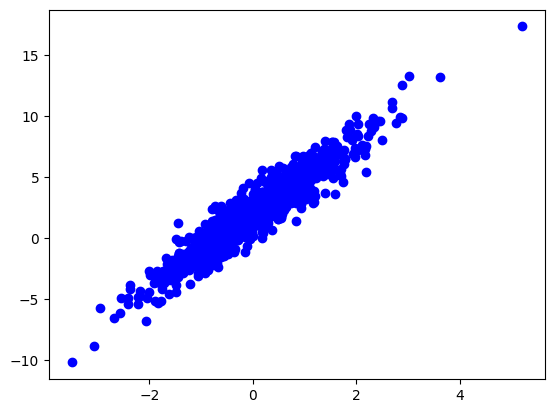

In [3]:
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000


x = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
y = x * TRUE_W + TRUE_B + noise

plt.scatter(x, y, c='b')

In [4]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # initial weights
    self.w = tf.Variable(5.0) # TRUE_W = 3.0
    self.b = tf.Variable(0.0) # TRUE_B = 2.0
    self.w_m = tf.Variable(0.0)
    self.b_m =  tf.Variable(0.0)

  def __call__(self, x):
    return (self.w*x + self.b) , ((self.w_m+self.w)*x + (self.b+self.b_m))

In [5]:
model = MyModel()

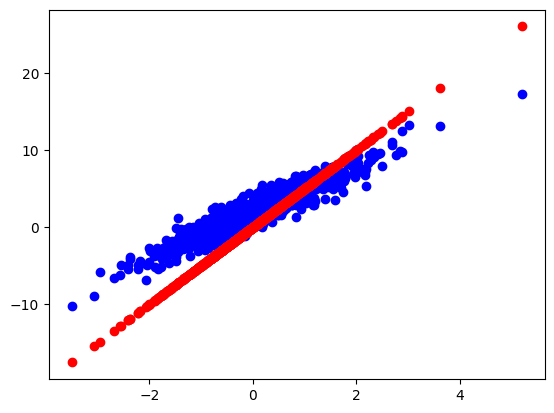

In [6]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y[0], c="r")

plt.show()


In [7]:
def nag_optimizer_train(model, x, y, learning_rate , momentum):

  with tf.GradientTape(persistent=True) as tape:
    y_hat , y_future = model(x)
    current_loss = MSE_loss(y, y_hat)
    future_loss = MSE_loss(y, y_future)

  dc_dw, dc_db = tape.gradient(current_loss, [model.w, model.b])
  df_dw, df_db = tape.gradient(future_loss, [(model.w_m+model.w), (model.b+model.b_m)])
  mw_new = momentum * model.w_m + learning_rate * dc_dw
  mb_new = momentum * model.b_m + learning_rate * dc_db

  model.w.assign_sub(mw_new) # w = w - n * grad => w -= n*grad_w
  model.b.assign_sub(mb_new) # b = b - n * grad => b -= n*grad_b
  model.b_m.assign(mb_new)
  model.w_m.assign(mw_new)
  return current_loss

In [8]:
model = MyModel()

Ws, bs , mw , mb  = list(), list() , list() , list()
LOSS = list()
epochs = 20

learning_rate = 0.9 # LARGE LEARNING RATE

w = model.w.numpy()
b = model.b.numpy()

init_loss = MSE_loss(y, model(x)).numpy()

print(f"initial W: {w}, initial_bias: {b}, initial loss: {init_loss}")

initial W: 5.0, initial_bias: 0.0, initial loss: 9.00039291381836


In [9]:
for epoch in range(epochs):
  nag_optimizer_train(model, x, y, learning_rate , momentum = 0.9)

  Ws.append(model.w.numpy())
  bs.append(model.b.numpy())
  mw.append(model.w_m.numpy())
  mb.append(model.b_m.numpy())
  current_loss = MSE_loss(y, model(x))
  LOSS.append(current_loss.numpy())

  print(f"For epoch: {epoch}, W: {Ws[-1]}, initial_bias: {bs[-1]}, current loss: {current_loss}")

For epoch: 0, W: 1.4576396942138672, initial_bias: 3.536123514175415, current loss: 7.250117301940918
For epoch: 1, W: 0.8515465259552002, initial_bias: 4.00238037109375, current loss: 7.3562188148498535
For epoch: 2, W: 3.9403820037841797, initial_bias: 0.8857681751251221, current loss: 6.205918312072754
For epoch: 3, W: 5.015417575836182, initial_bias: 0.05625319480895996, current loss: 6.0213623046875
For epoch: 4, W: 2.4116549491882324, initial_bias: 2.7440669536590576, current loss: 5.353376865386963
For epoch: 5, W: 0.9958045482635498, initial_bias: 3.842209815979004, current loss: 4.954596519470215
For epoch: 6, W: 3.106964588165283, initial_bias: 1.578014612197876, current loss: 4.642581462860107
For epoch: 7, W: 4.747430801391602, initial_bias: 0.2961333990097046, current loss: 4.11473274230957
For epoch: 8, W: 3.116757869720459, initial_bias: 2.153554916381836, current loss: 4.04022216796875
For epoch: 9, W: 1.3540306091308594, initial_bias: 3.544844627380371, current loss: 3

In [10]:
data = pd.DataFrame({"W": Ws, "b": bs, "mw": mw, "mb": mb})

In [11]:
data["w_true"] = TRUE_W
data["b_true"] = TRUE_B

In [12]:
data['epoch'] = range(epochs)
data['loss'] = LOSS

In [13]:
data.iplot(kind="scatter" , x="epoch", y=["W" , "b" , "w_true" , "b_true"], mode="lines+markers", title="W vs epoch")

In [14]:
data.iplot(kind="scatter" , x="epoch", y=["loss", "W" , "b" ], mode="lines+markers", title="W vs epoch")

In [15]:
x.shape , y.shape

(TensorShape([1000]), TensorShape([1000]))

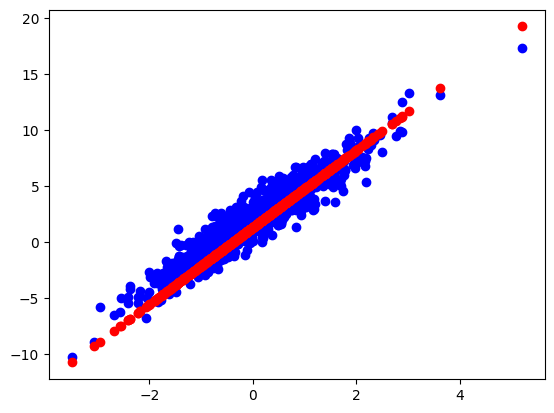

In [16]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y[0], c="r")

plt.show()

In [17]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full
X_test = X_test 
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [18]:
%%timeit
LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Dense(10, activation="softmax")]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2,mode="min" ,monitor='val_loss',restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard("tensor_board_logs")
model_normalized_batch= tf.keras.models.Sequential(LAYERS)
model_normalized_batch.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=1e-3 , momentum=0.9 ,nesterov=True), metrics=["accuracy"])
history = model_normalized_batch.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
1719/1719 [==============================] - 24s 14ms/step - loss: 0.5584 - accuracy: 0.8057 - val_loss: 0.4267 - val_accuracy: 0.8568
Epoch 2/30
1719/1719 [==============================] - 22s 13ms/step - loss: 0.4210 - accuracy: 0.8503 - val_loss: 0.4040 - val_accuracy: 0.8720
Epoch 3/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3856 - accuracy: 0.8617 - val_loss: 0.3780 - val_accuracy: 0.8718
Epoch 4/30
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3605 - accuracy: 0.8716 - val_loss: 0.3859 - val_accuracy: 0.8742
Epoch 5/30
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3413 - accuracy: 0.8771 - val_loss: 0.3820 - val_accuracy: 0.8794
Epoch 1/30
1719/1719 [==============================] - 24s 14ms/step - loss: 0.5524 - accuracy: 0.8069 - val_loss: 0.4342 - val_accuracy: 0.8548
Epoch 2/30
1719/1719 [==============================] - 24s 14ms/step - loss: 0.4184 - accuracy: 0.8503 - val_loss: 0.4051 - 

#### Drawbacks 
$ \beta$  = one more parameter to tune , even though $ \beta$ = 0.9 works fine 
oscillation when it reaches the minimum as accumulation of the past momentum  
#### Advantage 
faster than momentum 
less oscillation around the minima  